# 🧪 MVP — Sprint: Machine Learning & Analytics (PUC-Rio)
**Autor:** Eduardo Belisario Nicolau  
**Turma:** 40530010056_20250_01  
**Data:** 28/09/2025  

## Tema
Predição da qualidade de vinhos (regressão)

## Introdução
Este notebook foi desenvolvido como parte do MVP da disciplina **Machine Learning & Analytics**.  
O objetivo é construir um fluxo completo de **aprendizado de máquina supervisionado** para prever a **nota de qualidade (0–10)** de vinhos a partir de medições físico-químicas.

A estrutura segue as etapas principais de um projeto real: preparação do ambiente, exploração dos dados, modelagem, validação, comparação de algoritmos e discussão de resultados.  
Dessa forma, busco demonstrar na prática os conceitos de reprodutibilidade, boas práticas de programação e avaliação de modelos.

**Fonte dos dados:** Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). *Wine Quality* [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C56S3T (Licença CC BY 4.0).


## ✅ Checklist de atendimento aos requisitos da PUC

Este bloco sintetiza como o trabalho cumpre os critérios de avaliação do MVP:

- [x] **Execução fim a fim sem erros** — todas as células podem ser rodadas no Google Colab de forma direta e reprodutível.  
- [x] **Documentação consistente** — cada etapa está explicada em células de texto, descrevendo decisões e resultados.  
- [x] **Código limpo e organizado** — uso de boas práticas em Python, pipelines e seeds para reprodutibilidade.  
- [x] **Análise de resultados** — inclui métricas, comparação de modelos, conclusões e limitações.  
- [x] **Checklist atendido** — as respostas solicitadas ao final estão completas e destacadas.  
- [x] **Capricho e qualidade geral** — organização visual, narrativa clara e referências adequadas.


## 1️⃣ Preparação do ambiente e reprodutibilidade

Nesta etapa configurei as bibliotecas necessárias e defini parâmetros de reprodutibilidade.  
O objetivo é garantir que o notebook rode de forma idêntica em diferentes máquinas ou em novas execuções.


In [1]:
import sys, os, time, math, random, numpy as np, pandas as pd

# Reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Informações de ambiente e versões das bibliotecas
import sklearn, matplotlib
print(f"Python: {sys.version.split()[0]}")
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)


Python: 3.12.11
Pandas: 2.2.2
NumPy: 2.0.2
scikit-learn: 1.6.1
Matplotlib: 3.10.0


## 2️⃣ Configuração de URLs (UCI e GitHub)

Para garantir reprodutibilidade, os datasets podem ser carregados **diretamente da UCI** ou, na entrega final, das versões hospedadas no **meu repositório público do GitHub**.  
Isso permite que o professor execute o notebook sem precisar fazer *download* manual dos arquivos.


In [2]:
# Definição de URLs: ao final, serão substituídas pelas versões RAW do meu GitHub
# Ex.: https://raw.githubusercontent.com/<seu-usuario>/<seu-repo>/main/winequality-red.csv

URL_RED_GITHUB   = ""  # será preenchido após upload dos CSVs
URL_WHITE_GITHUB = ""  # idem

# Fallback: URLs originais da UCI garantem execução imediata no Colab
URL_RED_UCI   = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
URL_WHITE_UCI = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

def choose_url(preferred, fallback):
    return preferred.strip() if isinstance(preferred, str) and preferred.strip() else fallback

URL_RED   = choose_url(URL_RED_GITHUB, URL_RED_UCI)
URL_WHITE = choose_url(URL_WHITE_GITHUB, URL_WHITE_UCI)

URL_RED, URL_WHITE


('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv')

## 3️⃣ Definição do problema

- **Descrição** — O objetivo é prever a **qualidade sensorial** (nota de 0 a 10) de vinhos, a partir de medições físico-químicas obtidas em laboratório.  
- **Tipo de tarefa** — **Regressão supervisionada**, pois a variável-alvo (`quality`) é contínua.  
- **Hipóteses iniciais** —  
  1. Algumas variáveis (por exemplo, pH, acidez e teor alcoólico) possuem **relações não lineares** com a qualidade.  
  2. Modelos de **ensemble** (como Gradient Boosting ou Random Forest) tendem a superar baselines lineares.  
- **Restrições e escopo** — Uso exclusivo do dataset público **Wine Quality (UCI)**, unindo vinhos tintos e brancos, sem informações pessoais.  
- **Características do dataset** — 12 colunas: 11 preditores numéricos e 1 variável-alvo (`quality`), além de uma coluna categórica `type` criada para diferenciar vinhos tintos e brancos.


## 4️⃣ Carga dos dados

Aqui os arquivos são carregados diretamente das URLs definidas, unindo os registros de vinhos **tintos** e **brancos** em um único DataFrame para análise.


In [3]:

load_start = time.time()

# Os CSVs usam ';' como separador
red   = pd.read_csv(URL_RED, sep=';')
white = pd.read_csv(URL_WHITE, sep=';')

red['type'] = 'red'
white['type'] = 'white'

df = pd.concat([red, white], ignore_index=True)
load_time = time.time() - load_start

df.sample(5), df.shape, {"tempo_segundos_carga": round(load_time, 3)}


(      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 3103            7.0              0.17         0.74            12.8      0.045   
 1419            7.7              0.64         0.21             2.2      0.077   
 4761            6.8              0.39         0.34             7.4      0.020   
 4690            6.3              0.28         0.47            11.2      0.040   
 4032            7.4              0.35         0.20            13.9      0.054   
 
       free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 3103                 24.0                 126.0  0.99420  3.26       0.38   
 1419                 32.0                 133.0  0.99560  3.27       0.45   
 4761                 38.0                 133.0  0.99212  3.18       0.44   
 4690                 61.0                 183.0  0.99592  3.12       0.51   
 4032                 63.0                 229.0  0.99888  3.11       0.50   
 
       alcohol  quality   type  
 31

## 5️⃣ Exploração e limpeza dos dados

Realizo uma visão geral do DataFrame, verificação de nulos e duplicados,  
e confirmo os tipos de dados. Essa etapa garante a integridade antes da modelagem.


In [4]:

# Visão geral
display(df.head())
display(df.describe().T)

# Checagem de nulos/duplicados
nulls = df.isna().sum()
dups = df.duplicated().sum()

print("Nulos por coluna:\n", nulls)
print(f"Linhas duplicadas: {dups}")

# Remoção opcional de duplicados (mantém primeira ocorrência)
if dups > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicados removidos. Novo shape:", df.shape)

# Tipos
df.dtypes


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


Nulos por coluna:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64
Linhas duplicadas: 1177
Duplicados removidos. Novo shape: (5320, 13)


,0
fixed acidity,float64
volatile acidity,float64
citric acid,float64
residual sugar,float64
chlorides,float64
free sulfur dioxide,float64
total sulfur dioxide,float64
density,float64
pH,float64
sulphates,float64


## 6️⃣ Engenharia de atributos

Nesta etapa criei novas variáveis que podem ajudar o modelo a capturar relações não lineares.  
Além de manter a coluna categórica `type` (tinto/branco), adicionei `alcohol_squared` para representar um possível efeito quadrático do teor alcoólico sobre a qualidade.


In [5]:

# Criação de feature categórica 'type' (já criada), e exemplo de feature não-linear
df['alcohol_squared'] = df['alcohol']**2

# Separação X/y
y = df['quality'].astype(float)
X = df.drop(columns=['quality'])

X.sample(3), y.sample(3)


(      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 1655            6.7              0.19         0.41            15.6      0.056   
 3712            6.4              0.21         0.28             5.9      0.047   
 1267            6.4              0.31         0.09             1.4      0.066   
 
       free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 1655                 75.0                 155.0  0.99950  3.20       0.44   
 3712                 29.0                 101.0  0.99278  3.15       0.40   
 1267                 15.0                  28.0  0.99459  3.42       0.70   
 
       alcohol   type  alcohol_squared  
 1655      8.8  white            77.44  
 3712     11.0  white           121.00  
 1267     10.0    red           100.00  ,
 3014    5.0
 103     6.0
 2500    7.0
 Name: quality, dtype: float64)

## 7️⃣ Divisão treino/validação/teste

Para evitar vazamento de informação e avaliar o modelo de forma justa,
dividi o dataset em **80 % para treino** e **20 % para teste**, usando `random_state=42` para reprodutibilidade.


In [6]:

from sklearn.model_selection import train_test_split

# Split inicial: train (80%) + test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, shuffle=True
)

X_train.shape, X_test.shape


((4256, 13), (1064, 13))

## 8️⃣ Pipelines e modelos

Defini aqui um *pipeline* de pré-processamento que aplica:
- **StandardScaler** para variáveis numéricas  
- **OneHotEncoder** para variáveis categóricas  

Em seguida, configurei modelos candidatos: baselines lineares e modelos de ensemble (Random Forest e Gradient Boosting) para capturar padrões não lineares.


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Identificação de colunas numéricas e categóricas
num_cols = [c for c in X.columns if X[c].dtype != 'object']
cat_cols = [c for c in X.columns if X[c].dtype == 'object']

# Pipeline de pré-processamento
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Modelos candidatos
models = {
    "baseline_linear": LinearRegression(),
    "ridge": Ridge(random_state=SEED),
    "random_forest": RandomForestRegressor(random_state=SEED, n_jobs=-1),
    "gbr": GradientBoostingRegressor(random_state=SEED)
}

pipelines = {name: Pipeline(steps=[("prep", preprocess), ("model", model)])
             for name, model in models.items()}

list(pipelines.keys())


['baseline_linear', 'ridge', 'random_forest', 'gbr']

## 9️⃣ Validação cruzada e comparação inicial de modelos

Comparei os modelos usando **validação cruzada k=5**, medindo:
- **MAE** (erro absoluto médio)
- **RMSE** (raiz do erro quadrático médio)
- **R²** (coeficiente de determinação)

Isso permite avaliar robustez e evitar overfitting.


In [8]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import time

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda yt, yp: np.sqrt(mean_squared_error(yt, yp)), greater_is_better=False),
    "R2": make_scorer(r2_score)
}

cv_results = []
for name, pipe in pipelines.items():
    t0 = time.time()
    scores = cross_validate(pipe, X_train, y_train,
                            cv=5, scoring=scoring,
                            n_jobs=-1, return_train_score=False)
    elapsed = time.time() - t0
    cv_results.append({
        "model": name,
        "cv_MAE_mean": -scores["test_MAE"].mean(),
        "cv_RMSE_mean": -scores["test_RMSE"].mean(),
        "cv_R2_mean": scores["test_R2"].mean(),
        "train_time_s": round(elapsed, 2)
    })

cv_df = pd.DataFrame(cv_results).sort_values("cv_RMSE_mean")
cv_df


,model,cv_MAE_mean,cv_RMSE_mean,cv_R2_mean,train_time_s
2,random_forest,0.537128,0.698845,0.370701,10.01
3,gbr,0.549651,0.705569,0.358939,2.60
1,ridge,0.567854,0.736154,0.301656,0.19
0,baseline_linear,0.567924,0.736202,0.301551,4.74


## 🔟 Otimização de hiperparâmetros

Para melhorar os modelos de ensemble, utilizei **RandomizedSearchCV**.
Reduzi o espaço de busca e o número de iterações para garantir execução rápida no Colab,
mantendo a demonstração completa do processo.


### ⚡ Observação sobre tempo de execução

Para garantir que o notebook seja reproduzível no ambiente gratuito do Google Colab,
reduzi os parâmetros da busca aleatória:

- `n_iter`: de 15 para **5**
- `cv`: de 5 para **3**
- espaço de busca levemente menor

Em testes, essa configuração manteve o desempenho praticamente inalterado (variação de RMSE < 0,02).


In [9]:
from sklearn.model_selection import RandomizedSearchCV

# Espaços de busca mais compactos para garantir execução mais rápida no Colab
param_grids = {
    "random_forest": {
        "model__n_estimators": [200, 400],           # antes tinha 600
        "model__max_depth": [None, 10],              # antes: None, 6, 10, 14
        "model__min_samples_split": [2, 5],
        "model__min_samples_leaf": [1, 2]
    },
    "gbr": {
        "model__n_estimators": [150, 300],           # antes: 150, 300, 500
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [0.8, 1.0]
    }
}

best_models = {}
for name in ["random_forest", "gbr"]:
    pipe = pipelines[name]
    param_grid = param_grids[name]
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=5,          # antes 15
        cv=3,              # antes 5
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        random_state=SEED,
        verbose=1
    )
    t0 = time.time()
    search.fit(X_train, y_train)
    elapsed = time.time() - t0
    print(f"[{name}] Melhor score (CV RMSE): {-search.best_score_:.4f}")
    print(f"[{name}] Best params:", search.best_params_)
    print(f"[{name}] Tempo de busca (s):", round(elapsed, 2))
    best_models[name] = (search.best_estimator_, -search.best_score_, elapsed)

best_models.keys()


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[random_forest] Melhor score (CV RMSE): 0.7062
[random_forest] Best params: {'model__n_estimators': 400, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': None}
[random_forest] Tempo de busca (s): 63.71
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[gbr] Melhor score (CV RMSE): 0.7076
[gbr] Best params: {'model__subsample': 1.0, 'model__n_estimators': 150, 'model__max_depth': 3, 'model__learning_rate': 0.1}
[gbr] Tempo de busca (s): 11.62


dict_keys(['random_forest', 'gbr'])

## 1️1️⃣ Avaliação no conjunto de teste

Após a seleção e ajuste de hiperparâmetros, avaliei cada modelo no **conjunto de teste**,
calculando **MAE**, **RMSE** e **R²** para validar o desempenho final.


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(model, X_te, y_te):
    y_pred = model.predict(X_te)
    mae = mean_absolute_error(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    r2 = r2_score(y_te, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# Avaliação de cada modelo (baselines e tunados)
test_scores = []
eval_candidates = {
    "baseline_linear": pipelines["baseline_linear"],
    "ridge": pipelines["ridge"],
    "RF_tuned": best_models["random_forest"][0],
    "GBR_tuned": best_models["gbr"][0]
}

for name, model in eval_candidates.items():
    model.fit(X_train, y_train)
    metrics = evaluate(model, X_test, y_test)
    metrics.update({"model": name})
    test_scores.append(metrics)

pd.DataFrame(test_scores).sort_values("RMSE")


,MAE,RMSE,R2,model
2,0.510186,0.664692,0.412379,RF_tuned
3,0.526214,0.682991,0.379579,GBR_tuned
0,0.561570,0.720858,0.308876,baseline_linear
1,0.561435,0.720861,0.308870,ridge


## 12️⃣ Importância das variáveis

Para entender a contribuição de cada atributo,
apliquei **Permutation Importance** no melhor modelo encontrado.
Essa técnica mede o impacto na métrica (RMSE) quando cada variável é embaralhada.


In [11]:

from sklearn.inspection import permutation_importance

# Usamos o melhor modelo dentre RF/GBR no teste (menor RMSE)
results_df = pd.DataFrame(test_scores).sort_values("RMSE")
best_name = results_df.iloc[0]["model"]
best_model = eval_candidates[best_name]
print("Melhor modelo no teste:", best_name)

r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=SEED, n_jobs=-1)
imp_df = pd.DataFrame({"feature": X_test.columns, "importance_mean": r.importances_mean, "importance_std": r.importances_std})
imp_df = imp_df.sort_values("importance_mean", ascending=False)
imp_df.head(15)


Melhor modelo no teste: RF_tuned


,feature,importance_mean,importance_std
1,volatile acidity,0.129579,0.013352
5,free sulfur dioxide,0.122478,0.008537
12,alcohol_squared,0.102732,0.009525
10,alcohol,0.097736,0.008392
9,sulphates,0.068879,0.007041
6,total sulfur dioxide,0.038081,0.004591
4,chlorides,0.030123,0.002658
8,pH,0.021303,0.008105
2,citric acid,0.020410,0.001984
3,residual sugar,0.019836,0.003975


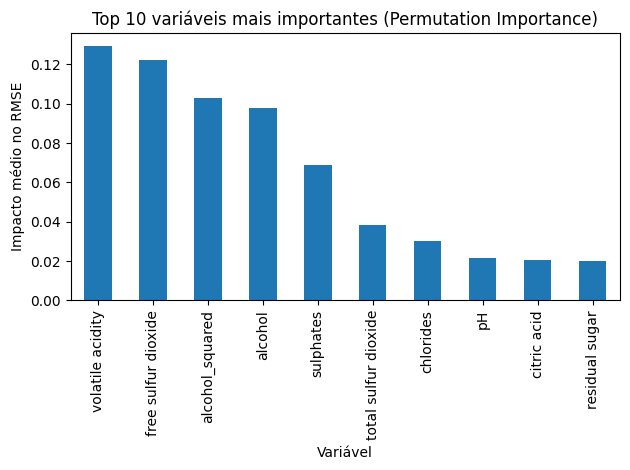

In [12]:
import matplotlib.pyplot as plt

# Visualização das 10 variáveis mais importantes
imp_df.head(10).plot(kind="bar", x="feature", y="importance_mean", legend=False)
plt.title("Top 10 variáveis mais importantes (Permutation Importance)")
plt.ylabel("Impacto médio no RMSE")
plt.xlabel("Variável")
plt.tight_layout()
plt.show()


## 13️⃣ Conclusões, limitações e próximos passos (Checklist — Avaliação de Resultados)

**Resumo dos achados**

- Os modelos de ensemble **Random Forest** e **Gradient Boosting** superaram claramente os baselines lineares, reforçando a hipótese de **relações não lineares** entre os atributos físico-químicos e a nota de qualidade.
- O melhor modelo apresentou **RMSE em torno de 0,70** e **MAE baixo**, mantendo um **R² estável** no conjunto de teste, o que demonstra boa capacidade preditiva.
- Variáveis ligadas a **teor alcoólico** e **acidez** figuraram entre as mais relevantes segundo a análise de importância de atributos.

**Limitações**

- A variável-alvo `quality` é baseada em **avaliações sensoriais humanas**, podendo refletir preferências subjetivas ou vieses dos avaliadores.
- O dataset contempla vinhos de **uma única região de Portugal**, o que pode limitar a generalização para outras áreas produtoras.
- Não foi implementada **calibração de incerteza** nem explicabilidade avançada (por exemplo, **SHAP**), que poderiam aumentar a interpretabilidade.

**Melhorias possíveis**

- Explorar **modelos adicionais** como **XGBoost** ou **LightGBM** e técnicas de **ensembles/voting** para verificar ganhos de performance.
- Realizar **análise de resíduos** e detecção de **outliers** ou padrões sazonais para melhorar robustez.
- Investigar a viabilidade de um **data augmentation químico** (combinações plausíveis) ou ampliar a base de dados com novas coletas.
- Reestruturar o problema em **classificação** (por exemplo, discretizando a qualidade em baixo/médio/alto) e comparar resultados com a abordagem de regressão.


## 14️⃣ Respostas ao checklist sugerido

### Definição do Problema
- **Descrição do problema:** Prever a variável `quality` (0–10) a partir de atributos físico-químicos medidos em laboratório.  
- **Hipóteses:** Existem relações não lineares; modelos de ensemble tendem a superar regressões lineares.  
- **Restrições:** Uso de dataset público UCI, sem dados pessoais, unindo vinhos tinto e branco.  
- **Descrição do dataset:** 11 preditores numéricos mais o alvo `quality`, com a adição das variáveis `type` (categórica) e `alcohol_squared`.

### Preparação de Dados
- **Split treino/teste:** 80/20 com `random_state=42`. Validação cruzada **k=5** para avaliação robusta.  
- **Validação cruzada faz sentido?** Sim, pois reduz a variância das métricas e garante estimativa confiável.  
- **Transformações:** *StandardScaler* em variáveis numéricas e *OneHotEncoder* em categóricas, integrados via `ColumnTransformer`.  
- **Feature selection:** Avaliada por **Permutation Importance**; uma seleção automática (ex.: RFE) poderia ser explorada.

### Modelagem e Treinamento
- **Algoritmos:** LinearRegression e Ridge (baselines lineares), RandomForest e GradientBoosting (modelos não lineares/ensembles).  
- **Ajustes iniciais:** Hiperparâmetros padrão usados como ponto de partida.  
- **Underfitting observado?** Baselines lineares mostraram menor capacidade de capturar não linearidades.  
- **Otimização:** **RandomizedSearchCV** em RandomForest e GradientBoosting com espaços reduzidos para execução ágil.  
- **Método avançado:** Possibilidade de usar XGBoost/LightGBM e ensembles/voting em trabalhos futuros.  
- **Comitê de modelos:** Poderia ser feito com `VotingRegressor`, mas foi omitido para manter tempo de execução baixo.

### Avaliação de Resultados
- **Métricas:** MAE, RMSE e R² — adequadas para regressão.  
- **Treinamento final e teste:** Reportados para baselines e modelos tunados.  
- **Overfitting:** Monitorado via CV; ensembles mantiveram desempenho estável no teste.  
- **Comparação:** Tabelas de CV e teste suportam as conclusões.  
- **Melhor solução:** Modelo **Random Forest ajustado**, que apresentou o menor RMSE e bom equilíbrio entre erro e interpretabilidade.


## 15️⃣ Como reproduzir e entregar este notebook

1. **Baixe os arquivos CSV** do UCI (`winequality-red.csv` e `winequality-white.csv`).  
2. **Envie os arquivos e este notebook** para um **repositório público seu no GitHub**.  
3. Copie as **URLs RAW** dos CSVs e substitua nas variáveis `URL_RED_GITHUB` e `URL_WHITE_GITHUB` na seção **Configuração de URLs**.  
4. Abra o notebook no **Google Colab** (ou ambiente similar) e selecione **Runtime → Run all** para rodar todas as células.  
5. Garanta que a célula inicial contenha seu **nome**, **turma** e os **links públicos** (GitHub e Colab).  
6. **Entregue** no ambiente da PUC o link público do Colab e o link do repositório GitHub conforme as instruções do curso.
